In [1]:
!pip install odefinterp --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 62.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 26.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 11.9 MB/s eta 

In [ ]:
import odeformer
from odeformer.model import SymbolicTransformerRegressor
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import torch, json
import numpy as np
from tqdm import tqdm

In [ ]:
def analyse_exp(x1_init_param=2.0, c1_param=0.5, inp_points=25, beam_size_param=2):
    dstr = SymbolicTransformerRegressor(from_pretrained=True)
    model_args = {'beam_size':beam_size_param, 'beam_temperature':0.1}
    dstr.set_model_args(model_args)
    
    # data creation
    times = np.linspace(1, 10, inp_points)
    x1_init, c1 = x1_init_param, c1_param
    x1 = x1_init * np.exp(c1 * times)
    trajectory = np.stack([x1], axis=1)
    
    # fitting the model
    candidates = dstr.fit(times, trajectory)
    dstr.print(n_predictions=1)
    pred_trajectory = dstr.predict(times, trajectory[0])
    
    # get the attentions and intermediate tokens
    all_attentions = dstr.get_stored_attentions()
    intermediate_tokens = list(dstr.get_intermediate_tokens().values())
    
    plt.plot(times, trajectory[:, 0], label='True X')
    plt.plot(times, pred_trajectory[:, 0], label='Predicted X', linestyle='--')
    #plt.plot(times, trajectory[:, 1], label='True Y')
    #plt.plot(times, pred_trajectory[:, 1], label='Predicted Y', linestyle='--')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Trajectory')
    plt.title('True vs Predicted Trajectories')
    plt.show()
    
    def stack_cross_attentions(all_attentions):
        """
        This function gathers the cross-attention tensors for tokens 6..11 and stacks them into:
          [num_layers=12, beam_size=5, num_heads=16, stacked_tokens=6, seq_len=50]
        Each original cross-attention has shape [12, 5, 16, 1, 50].
        """
        # Gather shapes
        # For each token i in [6..11], shape is [12, 5, 16, 1, 50]
        # We place each token along dimension 3 -> stacked_tokens.
        # So end shape: [12, 5, 16, 6, 50]
        tokens_range = (len(intermediate_tokens), 2 * (len(intermediate_tokens)))
        tok_count = tokens_range[1] - tokens_range[0] # + 1
        # We'll assume all have the same shape
        sample = torch.tensor(all_attentions[f"token_{tokens_range[0]}"]["cross_attention"])
        num_layers, beam_size, num_heads, _, seq_len = sample.shape
    
        # Prepare final tensor
        stacked = torch.zeros(num_layers, beam_size, num_heads, tok_count, seq_len)
    
        # Fill it
        for i, token_id in enumerate(range(tokens_range[0], tokens_range[1])):
            cross_attn = torch.tensor(all_attentions[f"token_{token_id}"]["cross_attention"])  # [12, 5, 16, 1, 50]
            # Remove the extra dimension
            cross_attn = cross_attn.squeeze(3)  # shape [12, 5, 16, 50]
            # Place it at dimension 3 => stacked[..., i, :]
            stacked[:, :, :, i, :] = cross_attn
    
        return stacked
    
    def build_cross_figure(cross_attn):
        """
        Build a Plotly figure with 2 dropdowns: block (decoder layer) and beam.
        cross_attn_5d shape: [num_layers=12, beam=5, num_heads=16, 6, 50].
        We plot each (block, beam) as a set of 17 traces: sum-of-heads + 16 heads.
        The top row is a single big heatmap for sum-of-heads (shape [6, 50]).
        The lower rows are 4×4 subplots each showing [6, 50] for a single head.
        """
        num_layers, beam_size, num_heads, tok_dim, seq_len = cross_attn.shape     # 12
    
        # Create subplots: row=1 for sum of heads, rows=2..5 for the 16 heads.
        fig = make_subplots(
            rows=5,
            cols=4,
            row_heights=[0.4, 0.15, 0.15, 0.15, 0.15],
            vertical_spacing=0.06,
            horizontal_spacing=0.05,
            specs=[
                [{"colspan": 4}, None, None, None],  # sum-of-heads
                [{}, {}, {}, {}],
                [{}, {}, {}, {}],
                [{}, {}, {}, {}],
                [{}, {}, {}, {}],
            ],
            subplot_titles=["Normalized Sum of Heads"] + [f"Head {i}" for i in range(num_heads)]
        )
    
        # Helper to map head index -> (row, col) in the 4×4 block
        def head_pos(i):
            row = (i // 4) + 2
            col = (i % 4) + 1
            return row, col
    
        # We'll create 17 traces per (block, beam). Each group has 1 "sum" + 16 heads.
        all_traces = []
        for layer_idx in range(num_layers):
            for b_idx in range(beam_size):
                # shape [num_heads, 6, 50]
                data_3d = cross_attn[layer_idx, b_idx]
                group_name = f"block_{layer_idx}-beam_{b_idx}"
    
                # sum-of-heads
                sum_map = data_3d.sum(dim=0)  # shape [6, 50]
                if sum_map.max() != 0:
                    sum_map = sum_map / sum_map.max()
                sum_trace = go.Heatmap(
                    z=sum_map.numpy(),
                    coloraxis="coloraxis",
                    name=group_name + "-sum",
                    visible=(layer_idx == 0 and b_idx == 0)  # show only for 0,0 initially
                )
                all_traces.append(sum_trace)
    
                # 16 heads
                for head_idx in range(num_heads):
                    hm = data_3d[head_idx]
                    if hm.max() != 0:
                        hm = hm / hm.max()
                    head_trace = go.Heatmap(
                        z=hm.numpy(),
                        coloraxis="coloraxis",
                        name=group_name + f"-head_{head_idx}",
                        visible=(layer_idx == 0 and b_idx == 0)
                    )
                    all_traces.append(head_trace)
    
        # Add them to figure, positioning in subplots
        # Each group has 17 traces. We'll add them in the same subplot positions.
        traces_per_group = 1 + num_heads
        for idx, trace in enumerate(all_traces):
            group_index = idx // traces_per_group
            which_in_group = idx % traces_per_group
            # sum trace is index 0, heads are index 1..16
            if which_in_group == 0:
                # sum-of-heads
                fig.add_trace(trace, row=1, col=1)
            else:
                head_idx = which_in_group - 1
                r, c = head_pos(head_idx)
                fig.add_trace(trace, row=r, col=c)
    
        # The updatemenus to toggle (block, beam) by toggling "visible" on/off
        def build_visibility(target_block, target_beam):
            """Return an array of booleans specifying which of the all_traces are visible."""
            vis = [False] * len(all_traces)
            grouping_count = num_layers * beam_size
            for group_i in range(grouping_count):
                blk = group_i // beam_size
                b   = group_i % beam_size
                if blk == target_block and b == target_beam:
                    start_idx = group_i * traces_per_group
                    end_idx   = start_idx + traces_per_group
                    for k in range(start_idx, end_idx):
                        vis[k] = True
            return vis
    
        # "Block" dropdown resets beam to 0
        block_buttons = []
        for blk in range(num_layers):
            block_buttons.append(
                dict(
                    label=f"Decoder Block {blk}",
                    method="restyle",
                    args=[
                        {"visible": build_visibility(blk, 0)}
                    ],
                )
            )
    
        # "Beam" dropdown resets block to 0
        beam_buttons = []
        for b_idx in range(beam_size):
            beam_buttons.append(
                dict(
                    label=f"Beam {b_idx}",
                    method="restyle",
                    args=[
                        {"visible": build_visibility(0, b_idx)}
                    ],
                )
            )
    
        updatemenus = [
            dict(
                type="dropdown",
                x=0.0,
                xanchor="left",
                y=1.25,
                yanchor="top",
                direction="down",
                showactive=True,
                buttons=block_buttons
            ),
            dict(
                type="dropdown",
                x=0.25,
                xanchor="left",
                y=1.25,
                yanchor="top",
                direction="down",
                showactive=True,
                buttons=beam_buttons
            )
        ]
    
        # Flip the y-axes so they aren't upside down
        for r in range(1, len(intermediate_tokens)):
            for c in range(1, len(intermediate_tokens) - 1):
                fig.update_yaxes(autorange='reversed', row=r, col=c)
    
        fig.update_layout(
            coloraxis=dict(colorscale="Viridis"),
            height=1000,
            width=800,
            updatemenus=updatemenus,
            title_text="Cross-Attention Visualization",
            title_x=0.5
        )
        fig.show()

    build_cross_figure(stack_cross_attentions(all_attentions))

In [ ]:
analyse_exp(c1_param=0.5)

In [ ]:
analyse_exp(c1_param=-0.5)

In [4]:
def analyse_and_save(c1_val, save_path, block_id_param=11):
    # Initialize model and generate data
    dstr = SymbolicTransformerRegressor(from_pretrained=True)
    dstr.set_model_args({'beam_size': 2, 'beam_temperature': 0.1})
    
    times = np.linspace(1, 10, 25)
    x1 = 2.0 * np.exp(c1_val * times)
    trajectory = np.stack([x1], axis=1)
    
    # Run model and get attention data
    dstr.fit(times, trajectory)
    all_attentions = dstr.get_stored_attentions()
    intermediate_tokens = list(dstr.get_intermediate_tokens().values())
    
    # Dynamic token range based on intermediate tokens
    tokens_range = (len(intermediate_tokens), 2 * len(intermediate_tokens))
    token_ids = range(tokens_range[0], tokens_range[1])
    ytick_labels = [intermediate_tokens[i][-1][1][-1] for i in range(0, len(intermediate_tokens))]
    
    # Get cross-attention data for block 11, beam 0
    block_idx, beam_idx = block_id_param, 0
    cross_attns = []
    
    for token_id in token_ids:
        attn = torch.tensor(all_attentions[f"token_{token_id}"]["cross_attention"])
        cross_attns.append(attn)
    
    # Stack and process attention data
    stacked = torch.cat(cross_attns, dim=3)  # [layers, beam, heads, tokens, seq]
    block_data = stacked[block_idx, beam_idx]  # [heads, tokens, seq]
    
    # Create figure layout
    num_heads = block_data.shape[0]
    fig = plt.figure(figsize=(24, 20))
    gs = fig.add_gridspec(5, 4, height_ratios=[1, 1, 1, 1, 1])
    
    # Plot settings
    xtick_labels = [f"t={t:.1f}\nx={x:.2f}" for t, x in zip(times, x1)]
    xticks = np.arange(len(times))
    yticks = np.arange(len(ytick_labels))
    
    # Plot 1: Sum of all heads
    ax1 = fig.add_subplot(gs[0, :])
    sum_attn = block_data.sum(dim=0).numpy()
    if sum_attn.max() > 0:
        sum_attn /= sum_attn.max()
    im = ax1.imshow(sum_attn, cmap='viridis', aspect='auto')
    ax1.set_title(f"Block 11 Beam 0 - Sum of All Heads (c1={c1_val:.1f})", pad=20)
    ax1.set_xticks(xticks[::2])
    ax1.set_xticklabels(xtick_labels[::2], rotation=45, ha='right')
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ytick_labels)
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    
    # Plot 2-17: Individual heads in 4x4 grid
    for head_idx in range(num_heads):
        row = (head_idx // 4) + 1
        col = head_idx % 4
        ax = fig.add_subplot(gs[row, col])
        
        head_attn = block_data[head_idx].numpy()
        if head_attn.max() > 0:
            head_attn /= head_attn.max()
            
        ax.imshow(head_attn, cmap='viridis', aspect='auto')
        ax.set_title(f"Head {head_idx}")
        ax.set_xticks(xticks[::4])
        ax.set_xticklabels(xtick_labels[::4], rotation=45, ha='right')
        ax.set_yticks(yticks[::2])
        ax.set_yticklabels(ytick_labels[::2])

    plt.tight_layout()
    # plt.show()
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

  0%|          | 0/1 [00:00<?, ?it/s]

at decoder layer 11
Processing c1=-0.1
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


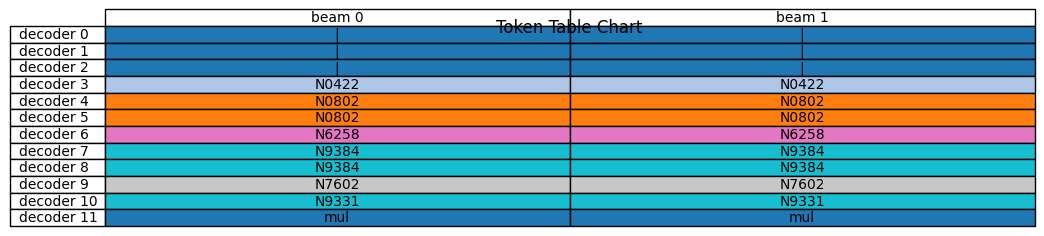

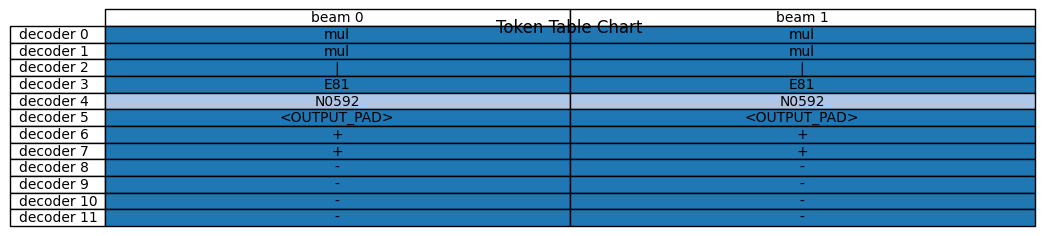

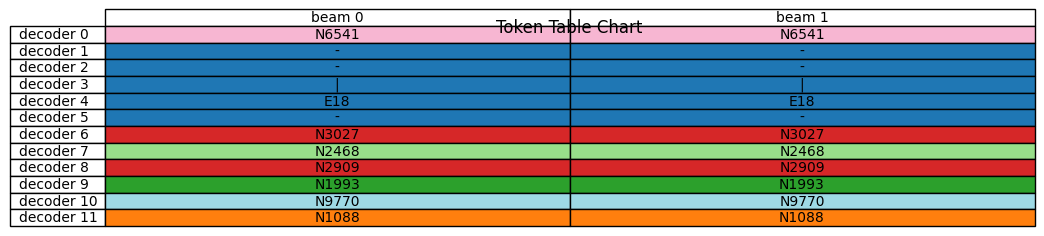

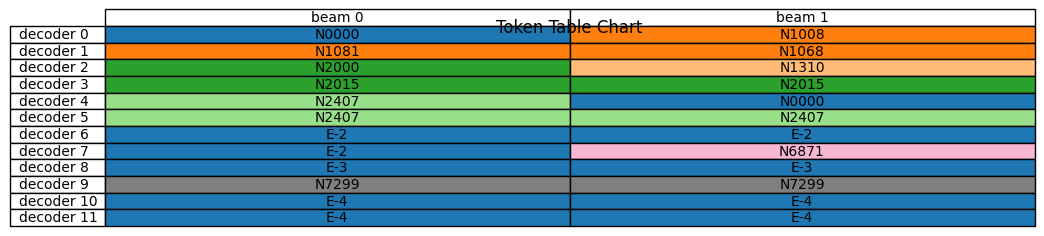

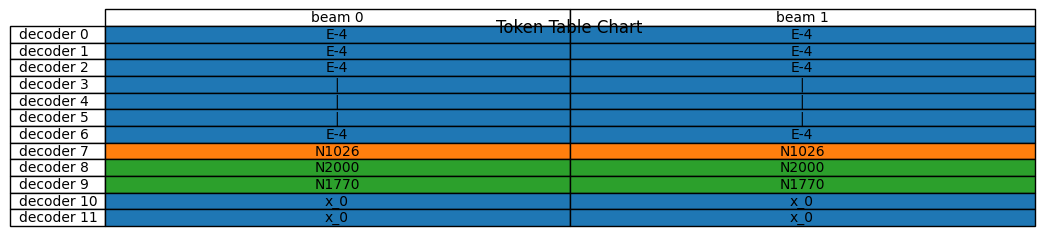

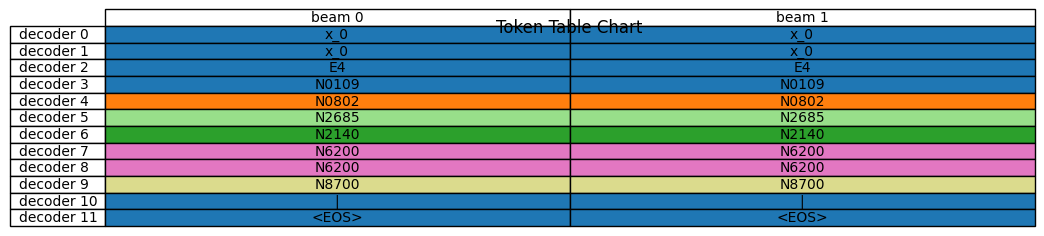

Processing c1=0.1
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


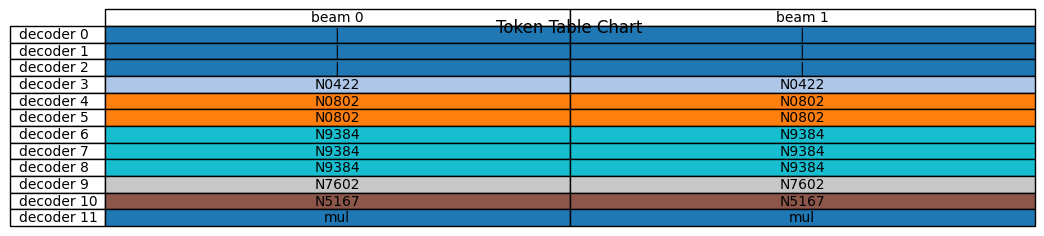

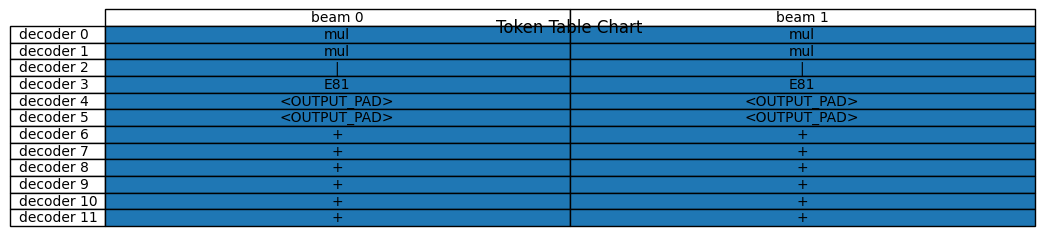

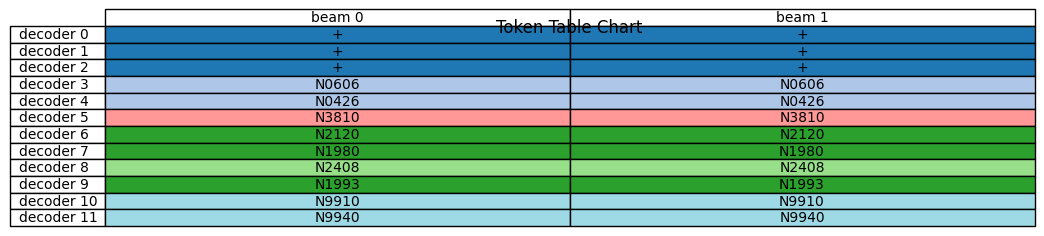

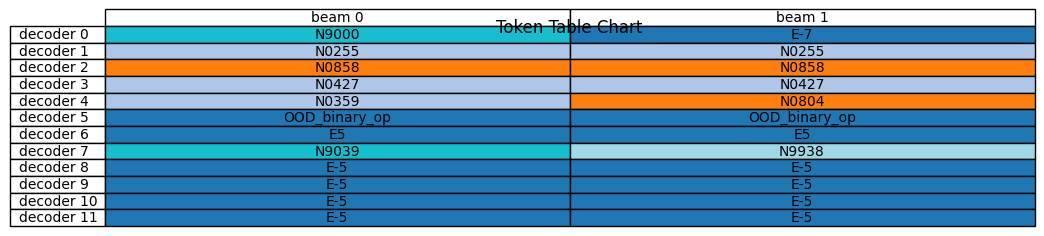

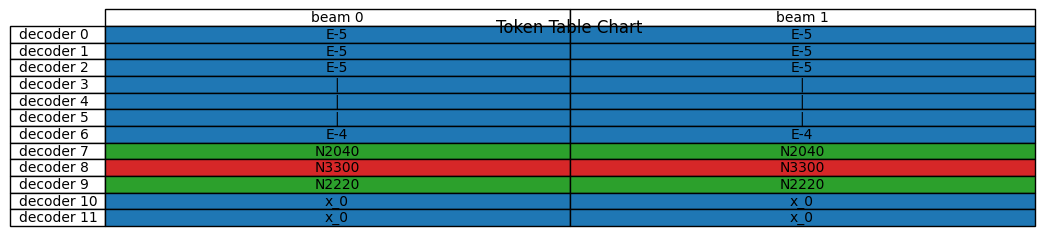

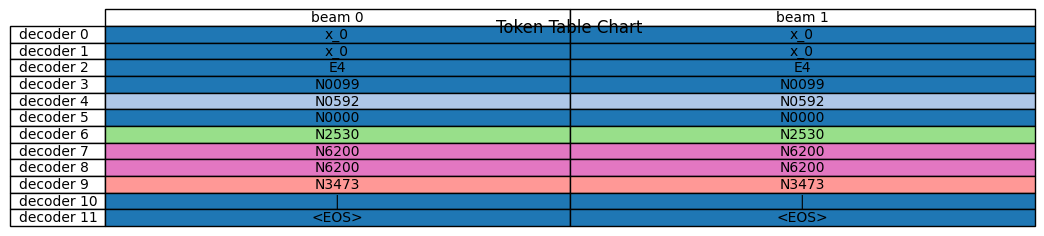

Processing c1=-0.2
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


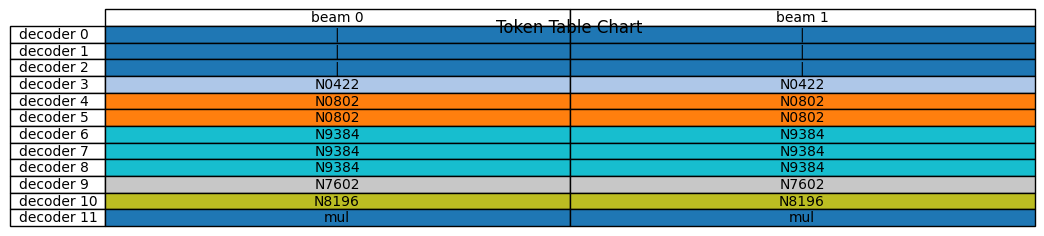

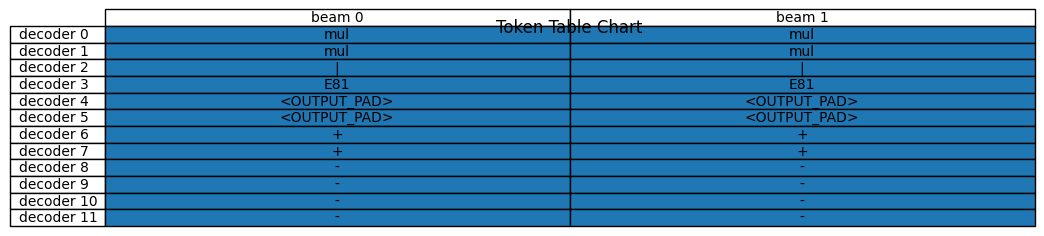

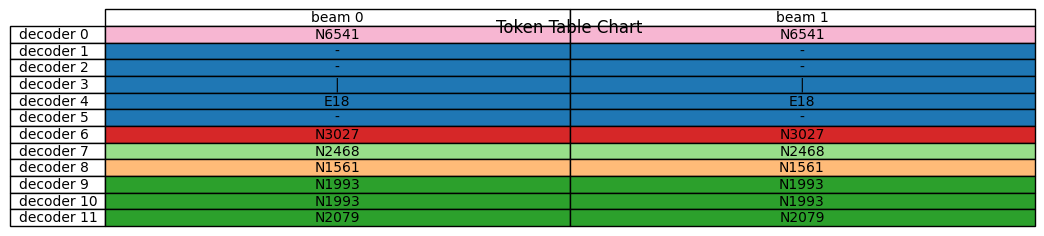

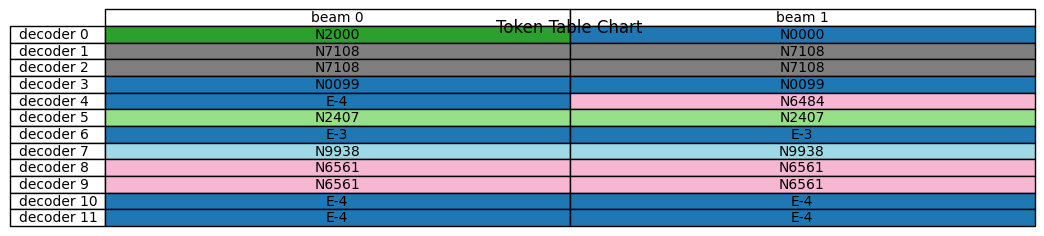

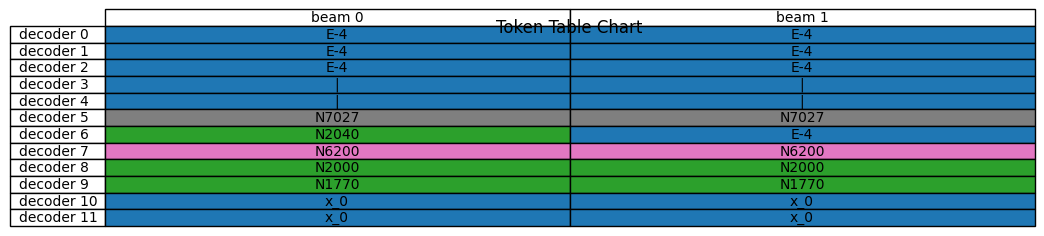

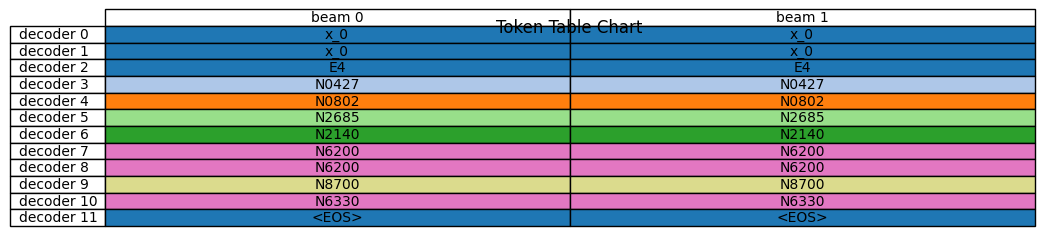

Processing c1=0.2
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


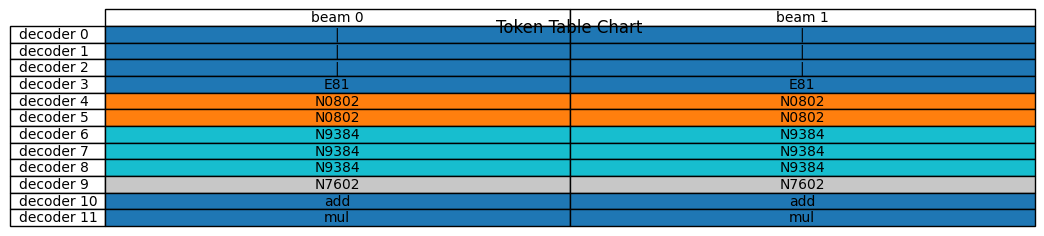

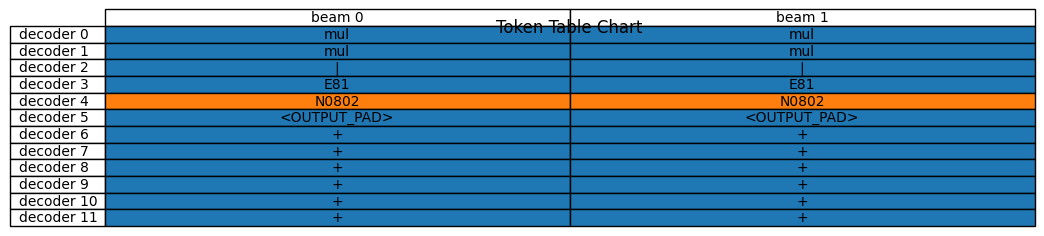

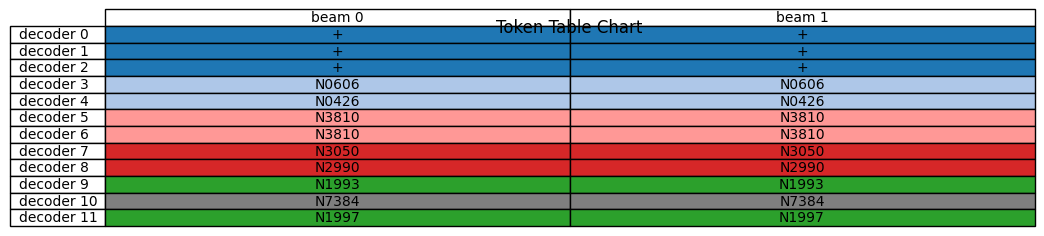

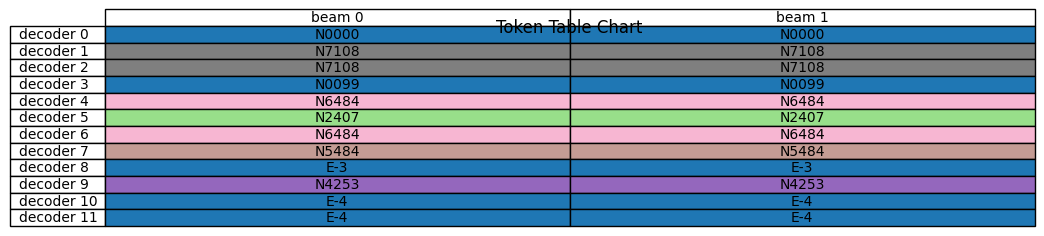

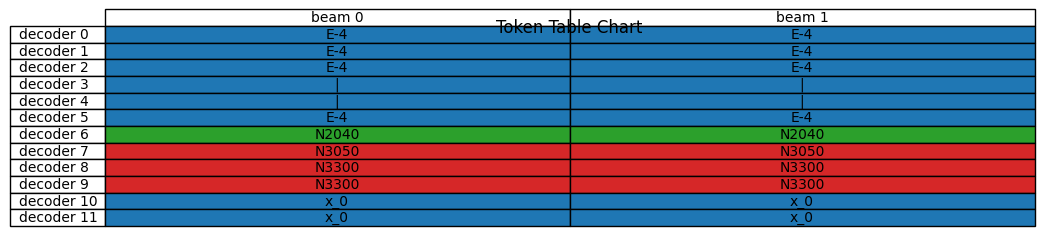

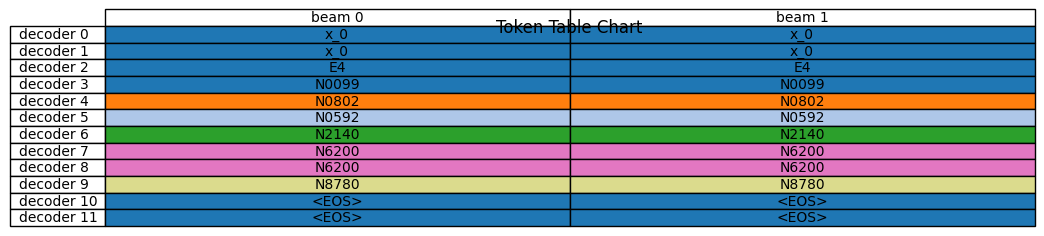

Processing c1=-0.3
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


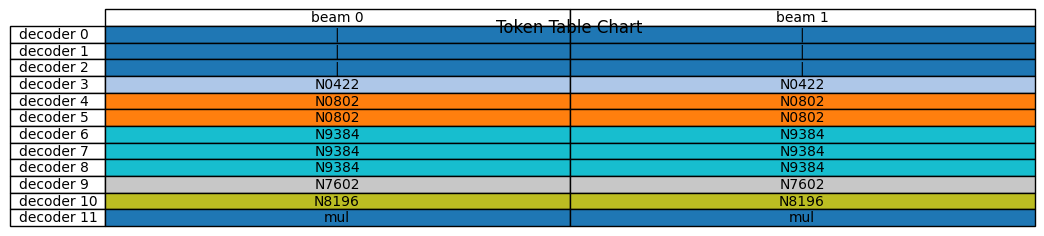

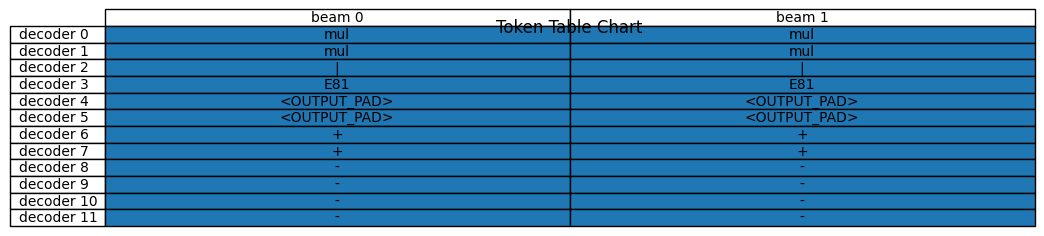

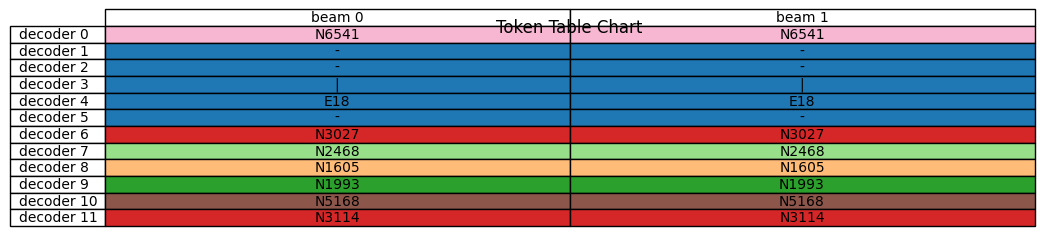

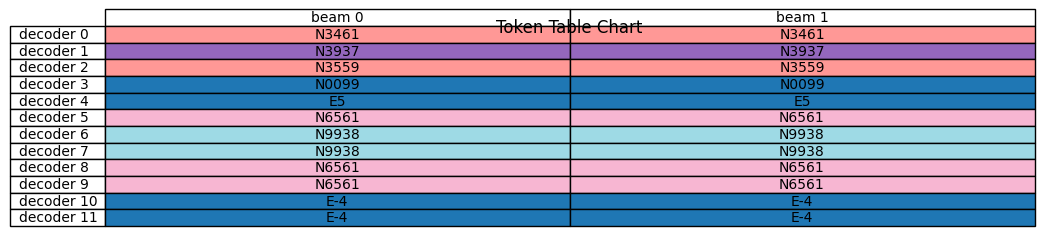

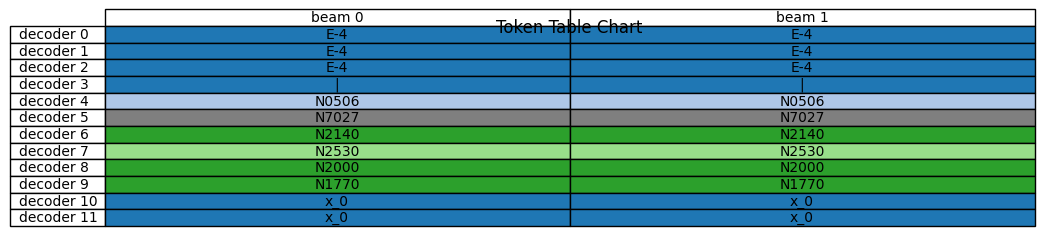

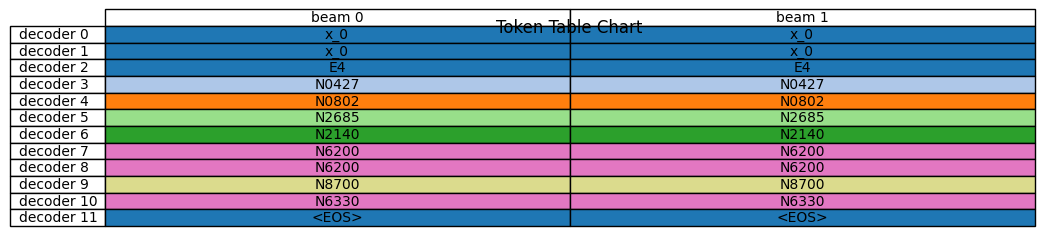

Processing c1=0.3
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


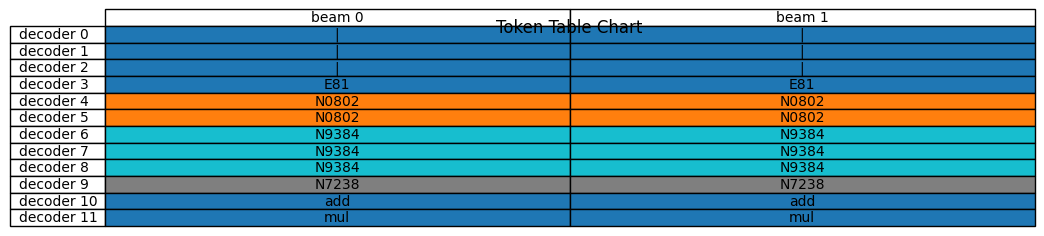

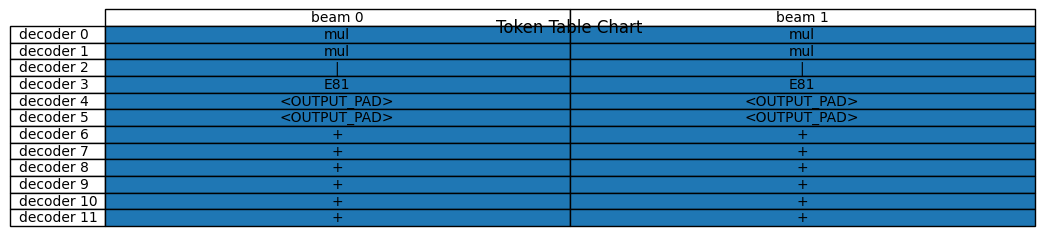

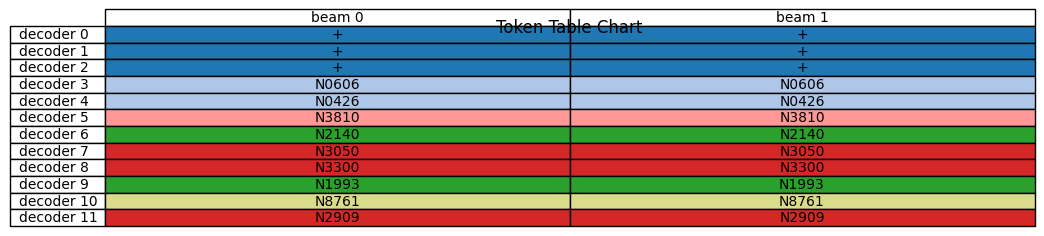

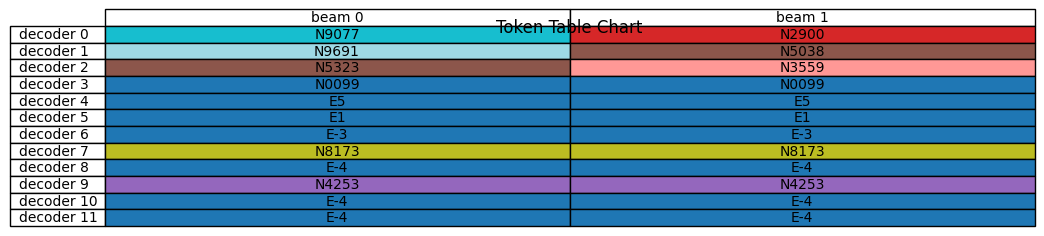

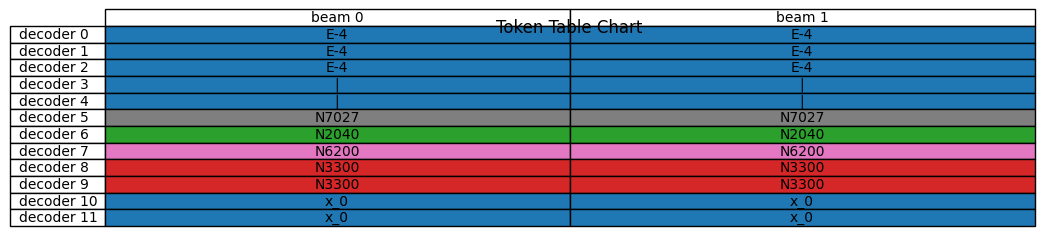

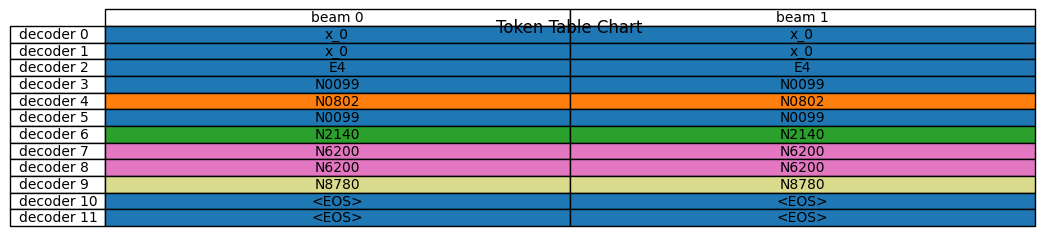

Processing c1=-0.4
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


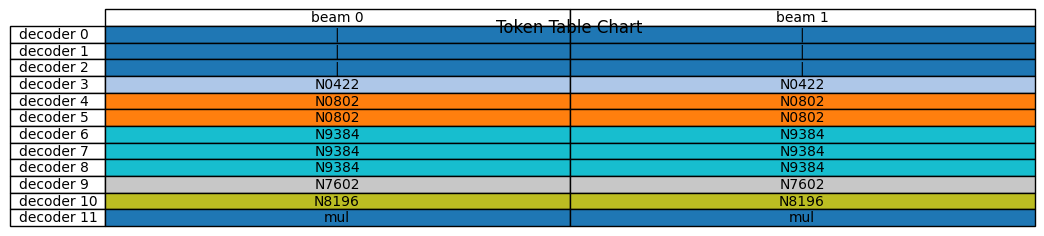

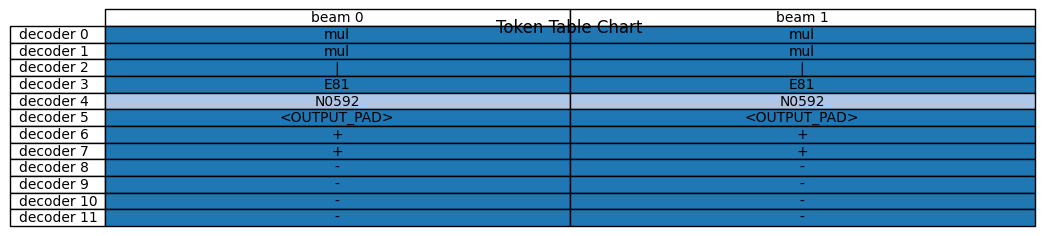

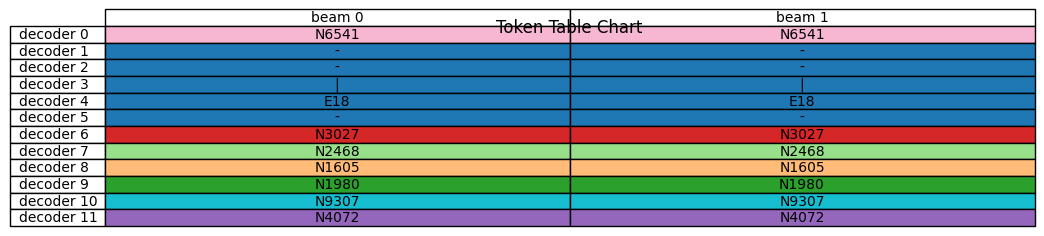

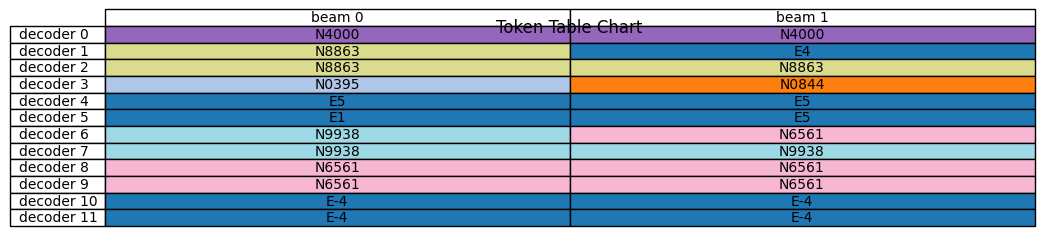

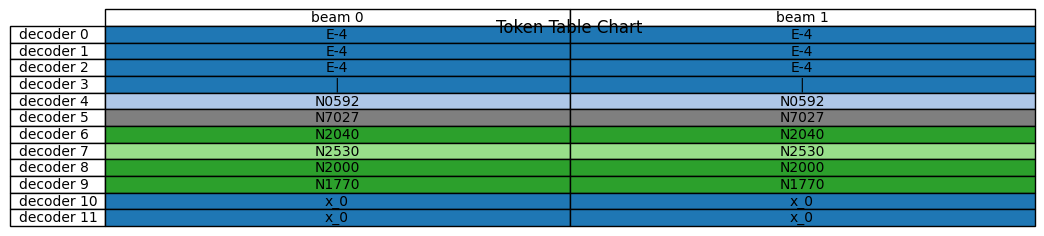

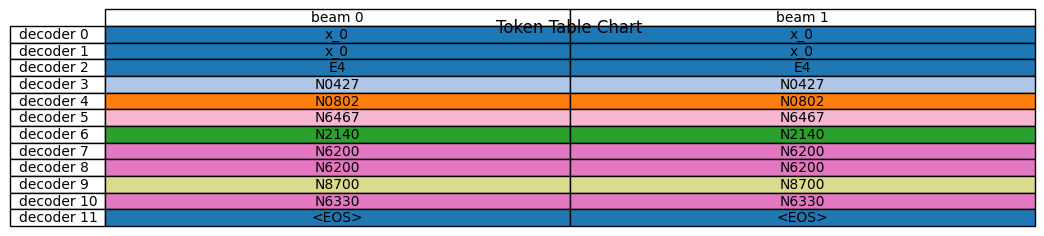

Processing c1=0.4
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


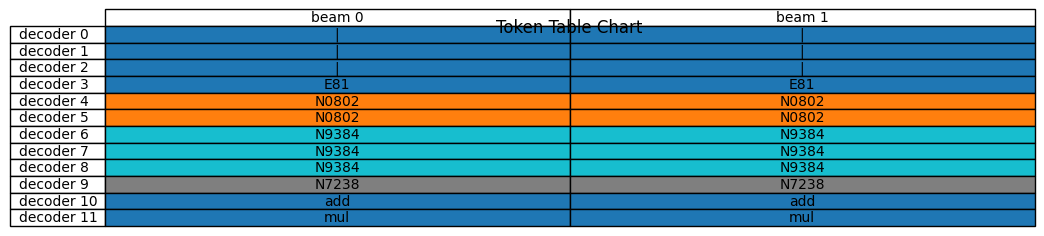

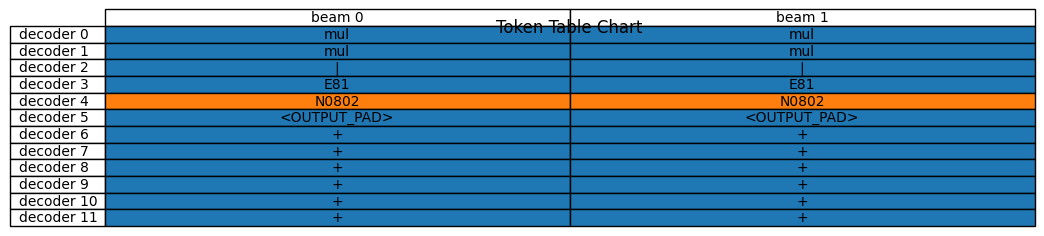

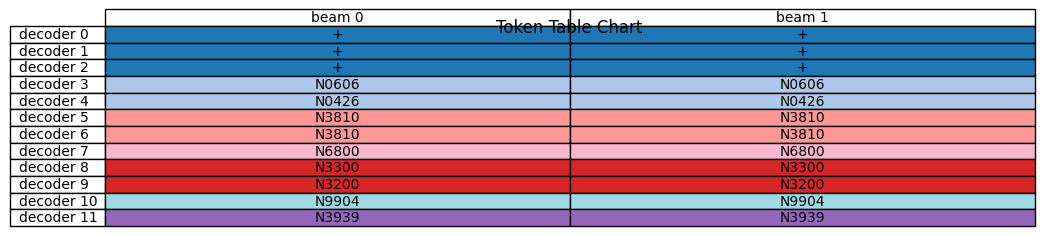

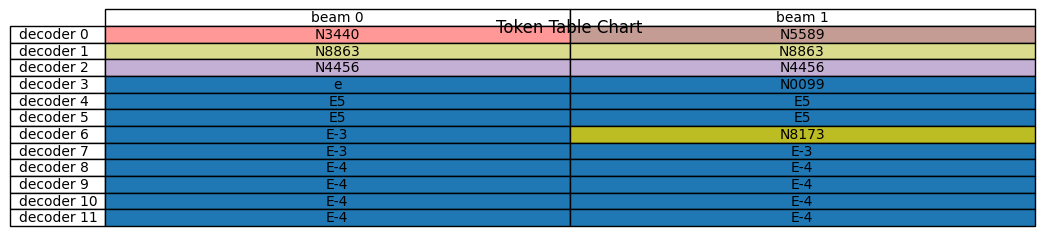

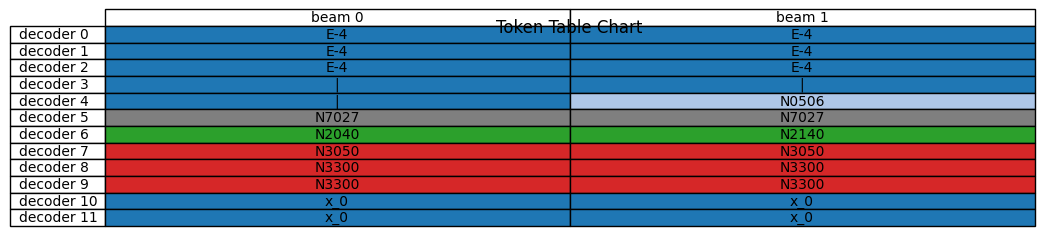

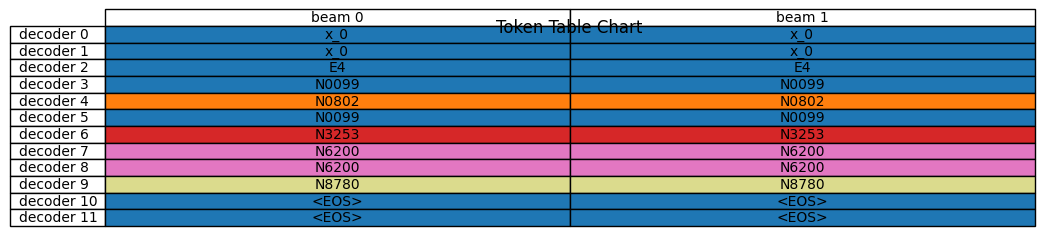

Processing c1=-0.5
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


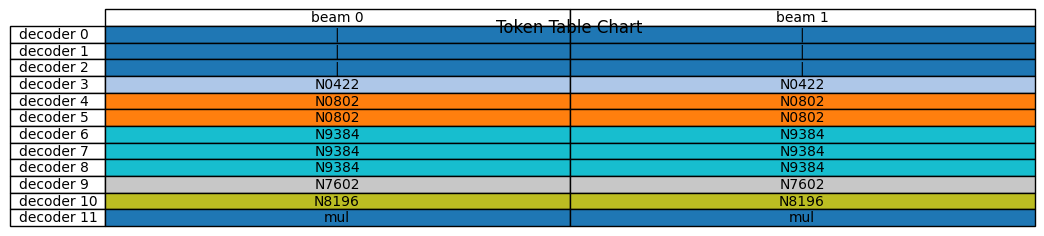

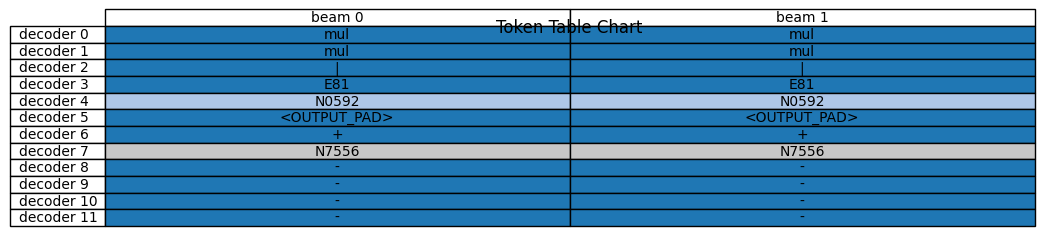

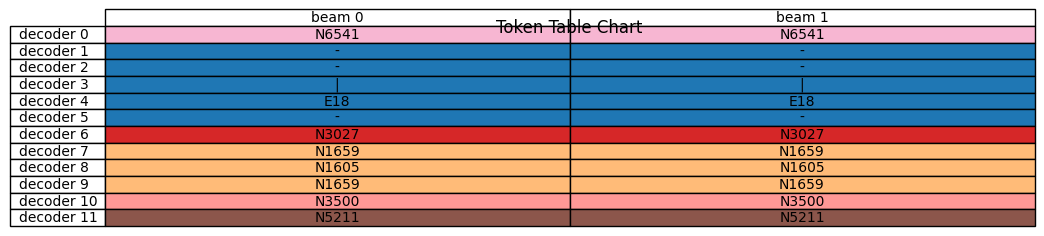

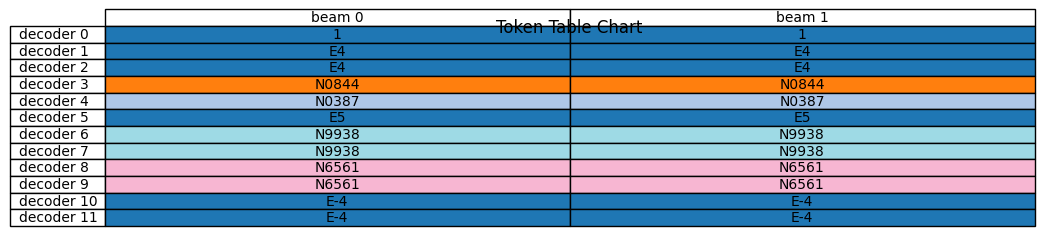

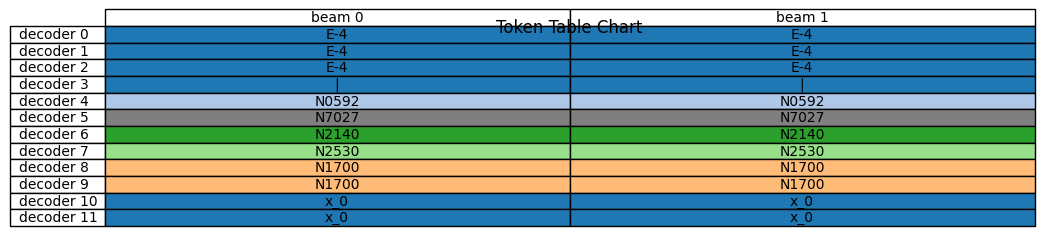

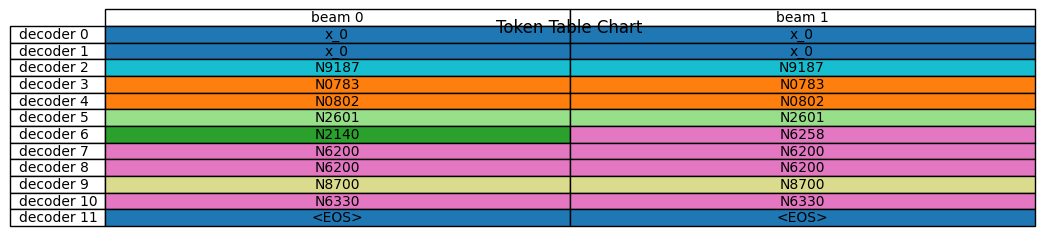

Processing c1=0.5
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


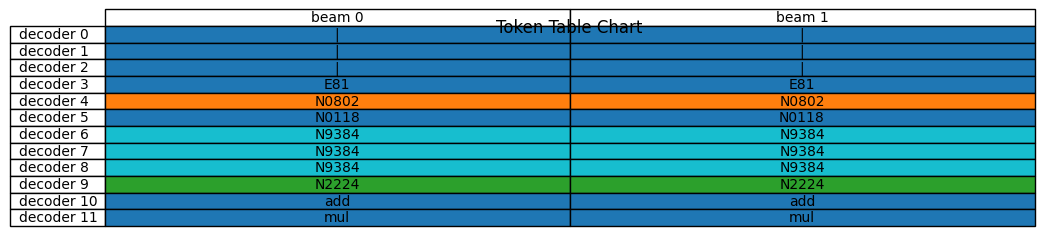

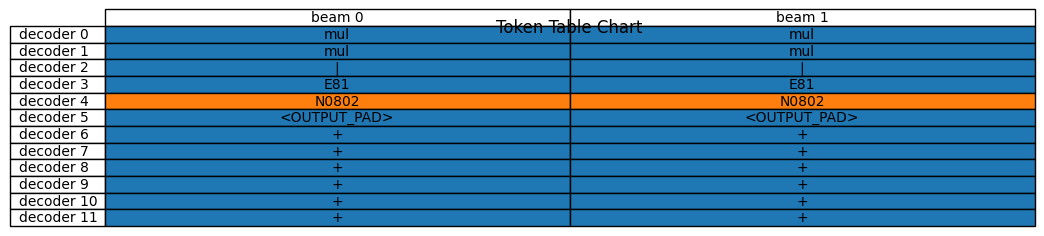

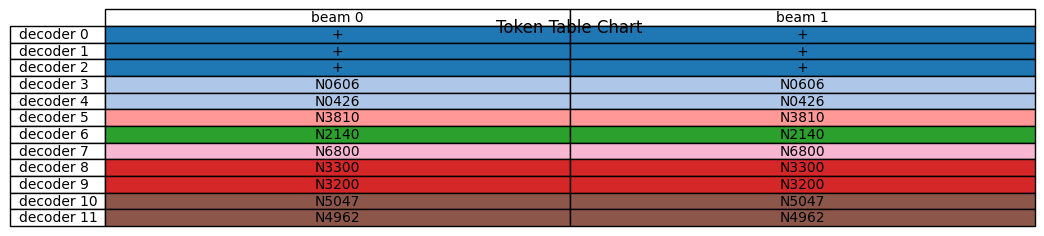

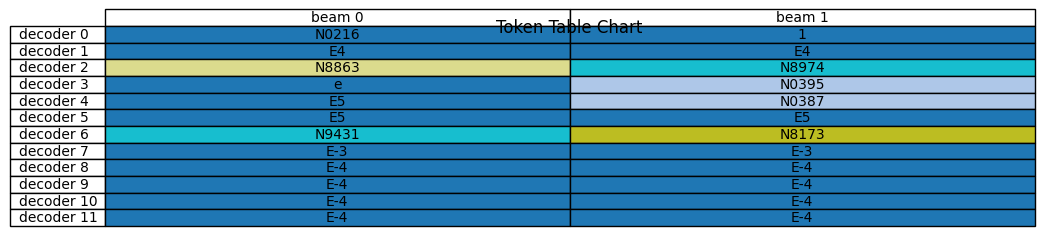

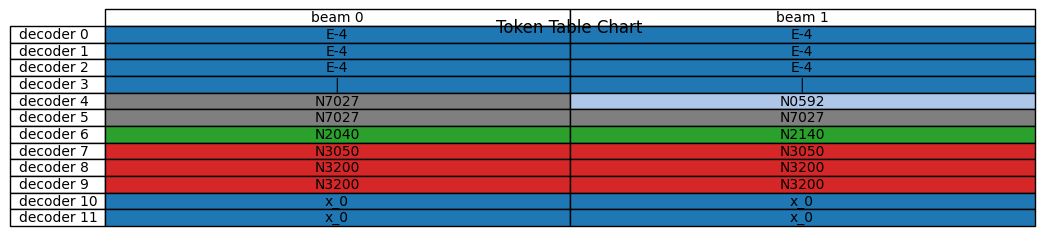

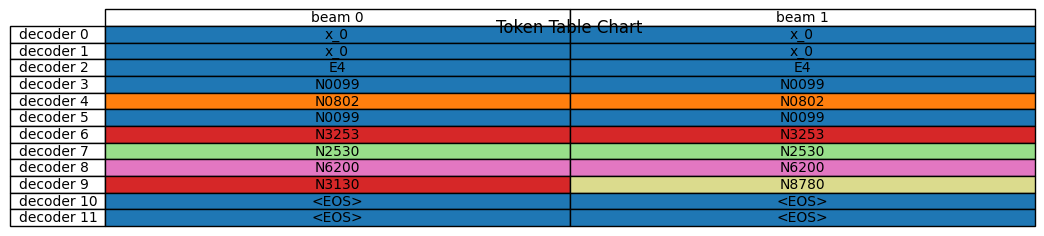

100%|██████████| 1/1 [01:08<00:00, 68.22s/it]


In [7]:
# Execution loop
for b in tqdm(range(11,12)):
    tqdm.write(f"at decoder layer {b}")
    for i in range(5):
        c1_val = -0.1 * (i + 1)
        save_path = f"/kaggle/working/c1_{-i-1}_crossattn_dec{b}.png"
        print(f"Processing c1={c1_val:.1f}")
        analyse_and_save(c1_val, save_path, b)
        c1_val = 0.1 * (i + 1)
        save_path = f"/kaggle/working/c1_{+i+1}_crossattn_dec{b}.png"
        print(f"Processing c1={c1_val:.1f}")
        analyse_and_save(c1_val, save_path, b)

In [9]:
!mkdir png_files && mv *.png png_files/ && zip -r png_files.zip png_files

  adding: png_files/ (stored 0%)
  adding: png_files/c1_-1_crossattn_dec11.png (deflated 27%)
  adding: png_files/c1_5_crossattn_dec11.png (deflated 24%)
  adding: png_files/c1_-5_crossattn_dec11.png (deflated 27%)
  adding: png_files/c1_1_crossattn_dec11.png (deflated 26%)
  adding: png_files/c1_2_crossattn_dec11.png (deflated 26%)
  adding: png_files/c1_-3_crossattn_dec11.png (deflated 27%)
  adding: png_files/c1_-2_crossattn_dec11.png (deflated 27%)
  adding: png_files/c1_3_crossattn_dec11.png (deflated 25%)
  adding: png_files/c1_-4_crossattn_dec11.png (deflated 27%)
  adding: png_files/c1_4_crossattn_dec11.png (deflated 24%)


In [8]:
!rm -r png_files png_files.zip

In [ ]:
!mkdir files

In [ ]:
# !mv dec* files/
!zip -r files.zip files

In [ ]:
import os
import re
import shutil

# Regular expression to match filenames ending with dec followed by a number (0-11)
pattern = re.compile(r'dec(\d+)\.png$', re.IGNORECASE)

for filename in os.listdir('.'):
    if os.path.isfile(filename) and filename.lower().endswith('.png'):
        match = pattern.search(filename)
        if match:
            number = int(match.group(1))
            if 0 <= number <= 11:  # Only process dec0 to dec11
                folder_name = f'dec{number}'
                # Create folder if it doesn't exist
                os.makedirs(folder_name, exist_ok=True)
                # Move file to the corresponding folder
                shutil.copy2(filename, os.path.join("/kaggle/working/", folder_name, filename))
                print(f'Moved {filename} to {folder_name}/')

In [ ]:
    # Initialize model and generate data
    dstr = SymbolicTransformerRegressor(from_pretrained=True)
    dstr.set_model_args({'beam_size': 2, 'beam_temperature': 0.1})
    
    times = np.linspace(1, 10, 25)
    x1 = 5.0 * np.exp(0.5 * times)
    trajectory_1 = np.stack([x1], axis=1)
    x2 = 2.0 * np.exp(0.5 * times)
    trajectory_2 = np.stack([x2], axis=1)
    
    # Run model and get attention data
    dstr.fit(times, trajectory_1)
    dstr.print(n_predictions=1)
    dstr.fit(times, trajectory_2)
    dstr.print(n_predictions=1)

### Some Observations:<br>
* Looked into the decoder_11's (last decoder layer) cross-attentions, varying the exponent c1 value: |1| to |5|. This was selected conciously because they all had 6 tokens as output *(almost all from |0.6| till |1.0| had more than 6 tokens due to the yapping nature of the transformer)*.
* In each plot saved, we observe that all the tokens attend to one or a few same points (most of the time) from the normalized summation of all the heads.
* However, closely observing the heads individually we find that `mul` and `+`/`-` most times depend on almost all of the input data points *(unlike the previous point)*.
* Now an interesting point about c1=0.6 and c1=-0.6. With 0.6, we get 6 tokens as output, but with -0.6 the model starts yapping and we end up getting a lot of tokens. But that's only according the token charts. When we closely observe this, we find that the decoder layers were executed 6 times to produce a skeleton tree of 6 tokens, and beam 0 indeed has the `<EOS>` token as the 6th token, but that isn't the last token. After that, we begin getting `N1010` because beam 1 is still in yapping mode. We think that `N1010` is some kind of a fallback-to-when-you-have-nothing token.
* The equation we were running was $y = A \cdot \exp(c_1 \cdot x)$. And we observed from our limited experimentation, that changing the `A` value resulted in no change in the resulting symbolic expression.